In [1]:
import numpy as np
import shapely
import json
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
import matplotlib.cm as cm

import rioxarray as rioxr
import rioxarray
import rasterio
import rasterio.plot as rplt
from rasterio.crs import CRS
from rasterio.merge import merge
from rasterio.mask import mask
from rasterio.io import MemoryFile
import rasterio.windows  as rw
from rasterio.enums import Resampling
from rasterio.transform import Affine

from scipy.spatial import cKDTree
from skimage import (color, data, filters, measure, morphology, segmentation,
                     util)
from matplotlib_scalebar.scalebar import ScaleBar
from typing import List, Any
import os
import pandas as pd

In [2]:
import sgl_processor_v03 as sgl # type: ignore
import sgl_utils # type: ignore
import geopandas as gpd
settings19 = sgl.ProcessorSGLSettings.from_range("20191201", "20200331")
sgl.initialize(settings19)
metas19 = sgl.get_metadata_from_csv(settings19.season_folder, ["tile-181", "tile-182", "tile-183"])
coll19 = sgl.create_collection_from_meta(settings19, metas19)

X=====================================================
SGLProcessor started for 20191201 to 20200331
X=====================================================
=====> Get metadata from .csv files.
=====> Create collection from csv meta.
     | 69 windows created for collection.


In [4]:
velocity_files = os.listdir(settings19.region_folder)
dmg_files = os.listdir(settings19.dmg_folder)
#print(velocity_files)
#print(dmg_files)

In [6]:
coll = coll19
settings = settings19

# Load Velocity data and calculate angle

300.0 -300.0


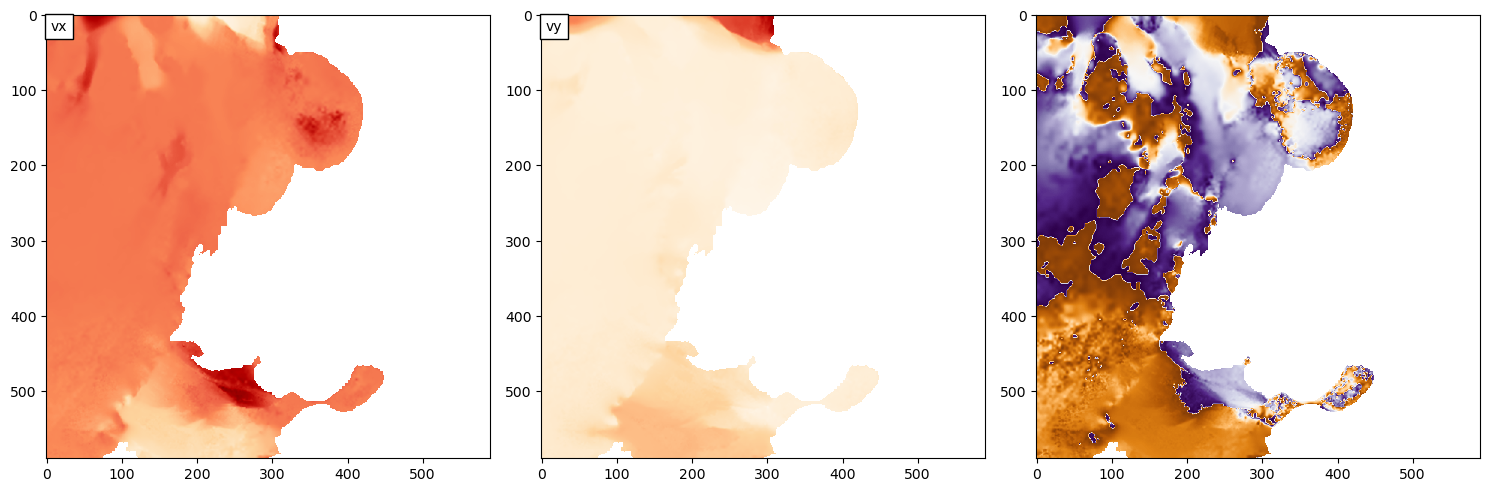

300.0 -300.0


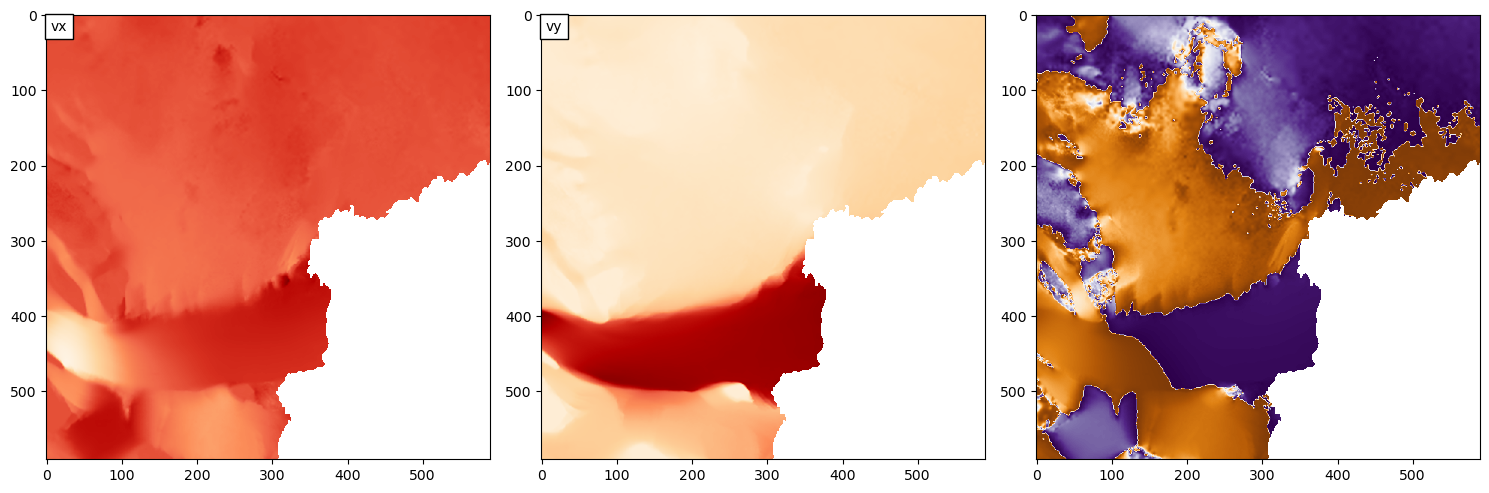

300.0 -300.0


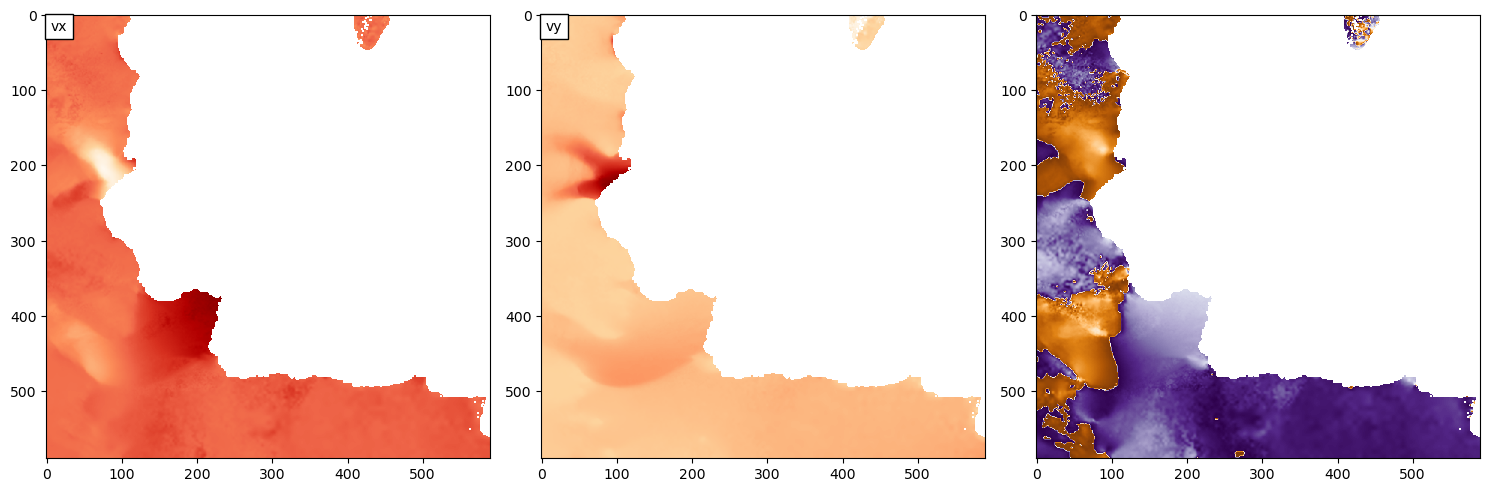

dict_keys(['name', 'file_vy', 'file_vx', 'vx', 'vy', 'alpha_v', 'dx', 'dy'])

In [10]:
all_results = []
for tile in coll.names:
    results = {}
    results["name"] = tile
    results["file_vy"] = [f for f in velocity_files if results["name"] in f and "vx" in f][0]
    results["file_vx"] = [f for f in velocity_files if results["name"] in f and "vy" in f][0]

    results["vx"] = rioxr.open_rasterio(os.path.join(settings.region_folder,results["file_vx"]))  # type: ignore
    results["vy"] = rioxr.open_rasterio(os.path.join(settings.region_folder,results["file_vy"]))  # type: ignore

    # Velocity angle
    results["alpha_v"] = np.arctan(results["vy"]/results["vx"])/(2*np.pi) * 360  # type: ignore
    # spatial resolution
    results["dx"] = np.unique(np.diff(results["vx"]['x'].values))[0]  # type: ignore
    results["dy"] = np.unique(np.diff(results["vy"]['y'].values))[0]  # type: ignore
    print(results["dx"],results["dy"])
    all_results.append(results)
    
    """
    """
    fig,axs = plt.subplots(1,3, figsize = (15, 5))
    ax = axs[0]
    rplt.show(results["vx"], ax=ax, cmap = "OrRd")
    ax.text(.01, .99, "vx", ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"))
    ax = axs[1]
    rplt.show(results["vy"], ax=axs[1], cmap = "OrRd")
    ax.text(.01, .99, "vy", ha='left', va='top', transform=ax.transAxes, bbox=dict(facecolor="white"))
    ax = axs[2]
    rplt.show(results["alpha_v"], ax=axs[2], cmap = "PuOr")
    plt.tight_layout()
    plt.show()
    #"""
all_results[0].keys()

# Load damage orientation

In [8]:
for tile in coll.names:
    tile_results = [r for r in all_results if r["name"] == tile][0]
    tile_results["file_alpha_c"] = [f for f in dmg_files if tile in f and "alpha" in f][0]
    tile_results["alpha_c"] = rioxr.open_rasterio(os.path.join(settings.dmg_folder,tile_results["file_alpha_c"]))  # type: ignore

all_results[0].keys()


dict_keys(['name', 'file_vy', 'file_vx', 'vx', 'vy', 'alpha_v', 'dx', 'dy', 'file_alpha_c', 'alpha_c'])

In [9]:
# Check if theta_p aligns with e_max or e_min
def check_theta_p_e11_e22(exx,eyy,exy,theta_p):
        
    E = np.array([ [exx.squeeze(), exy.squeeze() ], 
                [exy.squeeze(), eyy.squeeze() ] ]) # shape (x y n k) (2, 2, 494, 401) <-- should be (494, 401, 2, 2)

    Q = np.array([ [ np.cos(theta_p.squeeze()), np.sin(theta_p.squeeze())], 
                [-np.sin(theta_p.squeeze()), np.cos(theta_p.squeeze())] ])  # shape (x y k m) (2, 2, 494, 401) <-- should be (494, 401, 2, 2)      

    Qt = np.transpose(Q, (1, 0, 2, 3)) # (2, 2, 494, 401); transposed the (2,2) axes

    # move axes for np.matmul (from (2,2,x,y) to (x,y, 2, 2 ))
    E = np.moveaxis(E, [0, 1], [-2, -1]) # shape (494, 401, 2, 2); (x y n k)
    Q = np.moveaxis(Q, [0, 1], [-2, -1]) # shape (494, 401, 2, 2); (x y k m)
    Qt = np.moveaxis(Qt, [0, 1], [-2, -1]) #  shape (494, 401, 2, 2); (x y k m) 

    Edot = np.matmul(np.matmul(Q,E),Qt)

    # check single element:
    # i=2
    # j=6
    # print('Example: ')
    # print('emax {}, emin {}' .format(emax.squeeze()[i,j].values, emin.squeeze()[i,j].values))
    # print('E11: {}, E22: {}'.format(Edot[i,j,0,0],Edot[i,j,1,1]))

    # Update_theta_p to match e11
    e11 = Edot[:,:,0,0]
    e22 = Edot[:,:,1,1] 
    ndec = 6

    # idx where emax=e11, theta_p is correct 
    idx_e11_eq_emax = e11.round(ndec) == emax.values.round(ndec) 

    # idx where emax=e22, theta_p should be + 90 degree
    idx_e22_eq_emax = e22.round(ndec) == emax.values.round(ndec) 

    # if emax is not e11, it should be e22
    idx_correct = ~idx_e11_eq_emax == idx_e22_eq_emax 
    idx_correct[np.isnan(e11)] = True
    # --> check pixels where this is not true
    if not idx_correct.all():
        diff_e11 = np.nan_to_num(np.abs(emax-e11))
        diff_e22 = np.nan_to_num(np.abs(emax-e22)) 
        min_diff =  np.array((diff_e11,diff_e22)).min(axis=0)
        mindiff_e11_or_e22 = np.array((diff_e11,diff_e22)).argmin(axis=0) # 0 of minimum is found in e11; 1 if minimum diff is found in e22
        mindiff_e11_or_e22[idx_correct] = -999                # skip pixels that were already correct

        idx_e11_eq_emax[np.where(mindiff_e11_or_e22 == 0)] = True
        idx_e22_eq_emax[np.where(mindiff_e11_or_e22 == 1)] = True

        idx_correct = ~idx_e11_eq_emax == idx_e22_eq_emax 
        idx_correct[np.isnan(e11)] = True

    return idx_e22_eq_emax

In [10]:
for tile in coll.names:

    tile_results = [r for r in all_results if r["name"] == tile][0]
    

    # Prinicipal strain values 

    pix = 1  # number of pixels to shift
    res = tile_results["dx"] # spatial resolution of grid

    dudx = (tile_results["vx"] - tile_results["vx"].roll(x=pix) )/res
    dvdy = (tile_results["vy"] - tile_results["vy"].roll(y=pix) )/res
    dudy = (tile_results["vx"] - tile_results["vx"].roll(y=pix) )/res
    dvdx = (tile_results["vy"] - tile_results["vy"].roll(x=pix) )/res
    exx = 0.5*(dudx+dudx)
    eyy = 0.5*(dvdy+dvdy)
    exy = 0.5*(dudy+dvdx)
    emax_xr = (exx+eyy)*0.5 + np.sqrt(np.power(exx-eyy,2)*0.25+np.power(exy,2))
    emax = emax_xr.squeeze()

    emin_xr = (exx+eyy)*0.5 - np.sqrt(np.power(exx-eyy,2)*0.25+np.power(exy,2))
    emin = emin_xr.squeeze()
    # Orientation of principal strain
    emax.rio.to_raster(raster_path= os.path.join(settings.region_folder, tile_results["name"] + "_emax.tif"))
    emin.rio.to_raster(raster_path= os.path.join(settings.region_folder, tile_results["name"] + "_emin.tif"))

    tile_results["theta_p"] = (np.arctan(2*exy/(exx-eyy))/2) # in radiations
    #  Check if theta_p aligns with e_min or e_max, and update theta_p value + 0.25 pi
    idx_e22_eq_emax = check_theta_p_e11_e22(exx,eyy,exy,tile_results["theta_p"])
    tile_results["theta_p"] = tile_results["theta_p"].squeeze().values
    tile_results["theta_p"][idx_e22_eq_emax] +=  np.pi/4 # 90 degrees is 1/4 pi 

    theta_p_degr = tile_results["theta_p"]*360/(2*np.pi)
    # convert to xarray dataArray
    tile_results["theta_p_degr"] = emax_xr.copy(data=np.expand_dims(theta_p_degr,axis=0))


# Match Matrix grids

In [11]:
import rasterio as rio
for tile in coll.names:
    tile_results = [r for r in all_results if r["name"] == tile][0]
# reproject_match from rasterio

# -- match grid (extent, resolution and projection)
    tile_results["theta_p_match"] = tile_results["theta_p_degr"].rio.reproject_match(tile_results["alpha_c"],resampling=rio.enums.Resampling.nearest,nodata=np.nan) # need to specify nodata, otherwise fills with (inf) number 1.79769313e+308
    tile_results["alpha_v_match"] = tile_results["alpha_v"].rio.reproject_match(tile_results["alpha_c"],resampling=rio.enums.Resampling.nearest,nodata=np.nan) # need to specify nodata, otherwise fills with (inf) number 1.79769313e+308

all_results[0].keys()


dict_keys(['name', 'file_vy', 'file_vx', 'vx', 'vy', 'alpha_v', 'dx', 'dy', 'file_alpha_c', 'alpha_c', 'theta_p', 'theta_p_degr', 'theta_p_match', 'alpha_v_match'])

# Calculate relative Orientation

In [12]:
for tile in coll.names:
    tile_results = [r for r in all_results if r["name"] == tile][0]
# with theta_p and alpha_c in [-90 to 90], Dalpha=[-180 to 180]
    tile_results["delta_theta"] = tile_results["theta_p_match"] - tile_results["alpha_c"]
    tile_results["delta_alpha"] = tile_results["alpha_v_match"] - tile_results["alpha_c"]


    print(tile_results["delta_alpha"].min().values,tile_results["delta_alpha"].max().values) # [-180 180]
    print(tile_results["delta_theta"].min().values,tile_results["delta_theta"].max().values) # [-135 180]

-174.79629516601562 177.98062133789062
-129.96010971069336 177.10716247558594
-174.99530029296875 177.8139877319336
-129.89777755737305 177.5916976928711
-174.87850952148438 177.5199737548828
-128.95605087280273 176.46728515625


In [16]:
for tile in coll.names:
    outpath = settings.dmg_folder
    tile_results = [r for r in all_results if r["name"] == tile][0]
    tile_results["delta_alpha"].rio.to_raster(raster_path= os.path.join(outpath, "_".join(tile_results["file_alpha_c"].split("_")[:4]) + "_delta-alpha.tif"))
    #print(tile_results["file_alpha_c"].split("_")[:4] + "_delta-alpha.tif")